In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import os
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input

tf.__version__

/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

'1.14.0'

In [2]:
os.listdir('./data')

['DJI_ema.csv',
 'DJI_STO_20period_sma10.csv',
 'DJI_modified_sma.csv',
 '.DS_Store',
 'DJI_modified_features - DJI.csv',
 'DJI_fe.csv',
 'N225withoutNULL.csv',
 'dowjone1985_2019.csv',
 'N225fillVOL.csv',
 'test_djia.csv',
 'DJI_denoise.csv',
 'N225.csv',
 'stocknews',
 'preprocessed',
 'downjone5y.csv']

In [3]:
print("\n".join(os.listdir("./")))
df = pd.read_csv('data/N225withoutNULL.csv')

djia_support_nikkei_sync_period.ipynb
Simulator
Graph
DJI_STO_20period_sma10.csv
stock_with_news.ipynb
sentiment_roc_curve.ipynb
model_FE.ipynb
.git
Nikkie_NoFE.ipynb
loss_support_sync_data.png
.DS_Store
README.md
djia_support_nikkei.ipynb
ARIMA_model.ipynb
utils.py
__pycache__
baseline.ipynb
loss_support_sync_data2.png
djia_support_nikkei_sync_period_V2.ipynb
embedding_model.h5
seq2word_seq2seq.ipynb
AIAlpha.ipynb
loss_support.png
Paper
preprocess
model_nk_wo_fe.ipynb
.ipynb_checkpoints
data
join DJI and Nikkei.ipynb
saved_model
tmp
model_fe_too.ipynb


In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313,0
1,1985-01-30,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883,0
2,1985-01-31,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570,0
3,1985-02-01,11946.959961,11946.959961,11946.959961,11946.959961,11946.959961,0
4,1985-02-04,11891.080078,11891.080078,11891.080078,11891.080078,11891.080078,0


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000
mean,17127.378178,17230.332515,17015.456662,17123.019021,17123.019021,59729.515766
std,6094.196832,6114.941481,6070.241283,6093.569176,6093.569176,71179.395395
min,7059.770020,7100.770020,6994.899902,7054.979980,7054.979980,0.000000
25%,12331.404785,12386.577393,12270.609619,12321.304932,12321.304932,0.000000
50%,16802.924804,16923.285157,16656.660156,16790.860352,16790.860352,0.000000
75%,20442.700684,20560.332519,20328.775391,20454.067871,20454.067871,117200.000000
max,38921.648438,38957.441406,38827.710938,38915.871094,38915.871094,595200.000000


In [6]:
df = df.drop('Adj Close', axis=1)

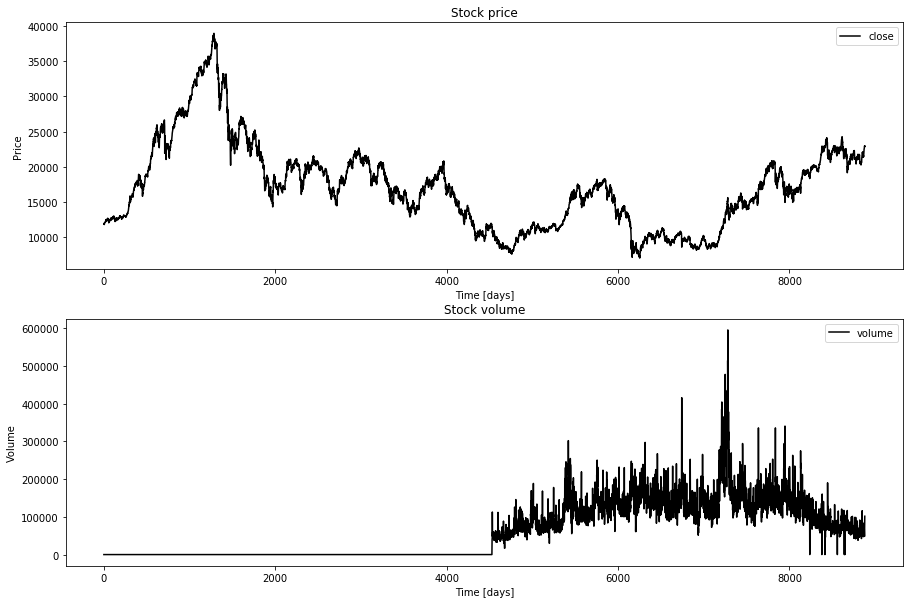

In [7]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(df['Close'], color='black', label='close')
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')


plt.subplot(2, 1, 2)
plt.plot(df['Volume'], color='black', label='volume')
plt.title('Stock volume')
plt.xlabel('Time [days]')
plt.ylabel('Volume')
plt.legend(loc='best')

In [8]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df['Open'].to_numpy().reshape(-1, 1))
    df['Low'] = min_max_scaler.fit_transform(df['Low'].to_numpy().reshape(-1, 1))    
    df['High'] = min_max_scaler.fit_transform(df['High'].to_numpy().reshape(-1, 1))    
    df['Close'] = min_max_scaler.fit_transform(df['Close'].to_numpy().reshape(-1, 1))
#     df['sma5'] = min_max_scaler.fit_transform(df['sma5'].to_numpy().reshape(-1, 1))
#     df['sma10'] = min_max_scaler.fit_transform(df['sma10'].to_numpy().reshape(-1, 1))
#     df['sma25'] = min_max_scaler.fit_transform(df['sma25'].to_numpy().reshape(-1, 1))
#     df['sma75'] = min_max_scaler.fit_transform(df['sma75'].to_numpy().reshape(-1, 1))
#     df['sma125'] = min_max_scaler.fit_transform(df['sma125'].to_numpy().reshape(-1, 1))
#     df['sma200'] = min_max_scaler.fit_transform(df['sma200'].to_numpy().reshape(-1, 1))
    #df['Volume'] = min_max_scaler.fit_transform(df['Volume'].to_numpy().reshape(-1, 1))  
    return df

def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = list()
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index+seq_len])
    data = np.array(data)
    val_set_size = int(np.round(val_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size + val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size + val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [9]:
df_index = df.drop('Date', axis=1)
df_index = df_index.drop('Volume', axis=1)


cols = list(df_index.columns.values)
print('Col : ', cols)

# rearrange columns ,for training with volume
# n_cols = cols[:3] + [cols[-1]] + [cols[-2]]
# df_index = df_index[n_cols] 

# print("new Cols: ",list(df_index.columns.values))





# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_index_norm = normalize_data(df_index)

# split train, val, test data

x_train, y_train, x_val, y_val, x_test, y_test = load_data(df_index_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

Col :  ['Open', 'High', 'Low', 'Close']
x_train.shape =  (7088, 19, 4)
y_train.shape =  (7088, 4)
x_val.shape =  (886, 19, 4)
y_val.shape =  (886, 4)
x_test.shape =  (886, 19, 4)
y_test.shape =  (886, 4)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [10]:
print(y_train[0]);
print("\n")
print(x_train[0]); 

[0.16136117 0.16010053 0.16354635 0.16151651]


[[0.15012612 0.14886365 0.15230105 0.15028112]
 [0.15381579 0.15255391 0.15599408 0.15397089]
 [0.15481007 0.15354836 0.15698927 0.15496521]
 [0.15338675 0.15212481 0.15556465 0.15354184]
 [0.15163293 0.1503707  0.15380923 0.15178797]
 [0.14950969 0.14824712 0.15168405 0.14966467]
 [0.1508825  0.14962015 0.15305811 0.15103752]
 [0.15319341 0.15193143 0.15537113 0.1533485 ]
 [0.15533421 0.15407259 0.15751389 0.15548937]
 [0.15533421 0.15407259 0.15751389 0.15548937]
 [0.15592676 0.15466524 0.15810698 0.15608194]
 [0.15585835 0.15459682 0.15803851 0.15601353]
 [0.15761533 0.15635408 0.15979709 0.15777055]
 [0.15970559 0.15844468 0.16188926 0.15986088]
 [0.15973259 0.15847168 0.16191628 0.15988788]
 [0.15996764 0.15870678 0.16215155 0.16012294]
 [0.15983364 0.15857275 0.16201743 0.15998894]
 [0.15908321 0.1578222  0.16126631 0.15923848]
 [0.15966697 0.15840605 0.1618506  0.15982226]]


In [11]:
df_index.head(20)

,Open,High,Low,Close
0,0.150126,0.148864,0.152301,0.150281
1,0.153816,0.152554,0.155994,0.153971
2,0.154810,0.153548,0.156989,0.154965
3,0.153387,0.152125,0.155565,0.153542
4,0.151633,0.150371,0.153809,0.151788
5,0.149510,0.148247,0.151684,0.149665
6,0.150883,0.149620,0.153058,0.151038
7,0.153193,0.151931,0.155371,0.153348
8,0.155334,0.154073,0.157514,0.155489
9,0.155334,0.154073,0.157514,0.155489


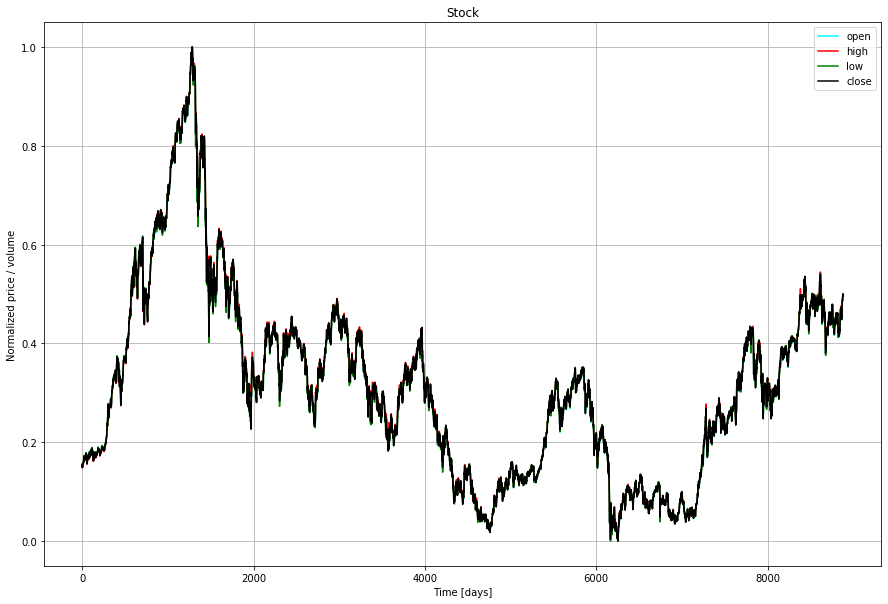

In [12]:
plt.figure(figsize=(15, 10))
plt.grid(True)
plt.plot(df_index_norm['Open'], color='cyan', label='open')
plt.plot(df_index_norm['High'], color='red', label='high')
plt.plot(df_index_norm['Low'], color='green', label='low')
plt.plot(df_index_norm['Close'], color='black', label='close')
# plt.plot(df_index_norm['sma5'], color='cyan', label='sma5')
# plt.plot(df_index_norm['sma10'], color='red', label='sma10')
# plt.plot(df_index_norm['sma25'], color='gray', label='sma25')
# plt.plot(df_index_norm['sma75'], color='purple', label='sma75')
# plt.plot(df_index_norm['sma125'], color='yellow', label='sma125')
# plt.plot(df_index_norm['sma200'], color='green', label='sma200')
plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend(loc='best')
plt.show()

In [13]:
from tensorflow.keras import backend as K
K.clear_session()

In [16]:
from tensorflow.keras.layers import Bidirectional,TimeDistributed,BatchNormalization,Flatten,LeakyReLU,Dropout

def get_bi_gru():
    
    input1 = Input(shape=(19,4,))
    x = Bidirectional(LSTM(256, return_sequences=True,  kernel_initializer='Orthogonal'))(input1)
    x = TimeDistributed(LeakyReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = GRU(128,kernel_initializer='Orthogonal')(x)
    x =(LeakyReLU())(x)
    x = (BatchNormalization())(x)
    x = (Dropout(0.25))(x)
    out = Dense(4,kernel_initializer='he_normal')(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(0.005),
                loss='mse',
                metrics=['mse'])   
    
    return model

In [17]:
model = get_bi_gru()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 19, 4)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 19, 512)           534528    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 19, 512)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 19, 512)           2048      
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               246144    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
print('start training ')


weight_path_model = "saved_model/nk_wo_fe.h5"
callbacks_list_model = [
    ModelCheckpoint(
             weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=2
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=4, min_lr=0.0001)
]

#################
batch_size = 64
epochs = 300
#################

history = model.fit(x_train, y_train, epochs=epochs, verbose=1, callbacks=callbacks_list_model,
          validation_data=(x_val, y_val),batch_size=batch_size) #batch_size=batch_size




start training 
Train on 7088 samples, validate on 886 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.2811 - mean_squared_error: 0.2811
Epoch 00001: val_loss improved from inf to 0.15832, saving model to saved_model/nk_wo_fe.h5
7088/7088 [==============================] - 14s 2ms/sample - loss: 0.2792 - mean_squared_error: 0.2792 - val_loss: 0.1583 - val_mean_squared_error: 0.1583
Epoch 2/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 00002: val_loss improved from 0.15832 to 0.08647, saving model to saved_model/nk_wo_fe.h5
7088/7088 [==============================] - 13s 2ms/sample - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0865 - val_mean_squared_error: 0.0865
Epoch 3/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 00003: val

Epoch 25/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 00025: val_loss did not improve from 0.00088
7088/7088 [==============================] - 40s 6ms/sample - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 26/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 00026: val_loss did not improve from 0.00088
7088/7088 [==============================] - 39s 6ms/sample - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 9.6374e-04 - val_mean_squared_error: 9.6374e-04
Epoch 27/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 00027: val_loss did not improve from 0.00088
7088/7088 [==============================] - 39s 6ms/sample - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0371 - val_mean_squared_error: 0.0371
Epoch 28/300
7040/7088 [=================

7040/7088 [============================>.] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 00050: val_loss did not improve from 0.00049
7088/7088 [==============================] - 39s 5ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 51/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 00051: val_loss did not improve from 0.00049
7088/7088 [==============================] - 38s 5ms/sample - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 52/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 00052: val_loss did not improve from 0.00049
7088/7088 [==============================] - 38s 5ms/sample - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 53/300
7040/7088 [============================>.] - ETA:

Epoch 76/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 00076: val_loss did not improve from 0.00018
7088/7088 [==============================] - 38s 5ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 7.8840e-04 - val_mean_squared_error: 7.8840e-04
Epoch 77/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 00077: val_loss did not improve from 0.00018
7088/7088 [==============================] - 39s 5ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 2.0075e-04 - val_mean_squared_error: 2.0075e-04
Epoch 78/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 00078: val_loss did not improve from 0.00018
7088/7088 [==============================] - 39s 6ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 2.0577e-04 - val_mean_squared_error: 2.0577e-04
Epoch 79/300
7040/7088 [=

Epoch 101/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 00101: val_loss improved from 0.00008 to 0.00008, saving model to saved_model/nk_wo_fe.h5
7088/7088 [==============================] - 40s 6ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 7.8480e-05 - val_mean_squared_error: 7.8480e-05
Epoch 102/300
7040/7088 [============================>.] - ETA: 0s - loss: 9.7026e-04 - mean_squared_error: 9.7026e-04
Epoch 00102: val_loss did not improve from 0.00008
7088/7088 [==============================] - 39s 5ms/sample - loss: 9.7083e-04 - mean_squared_error: 9.7083e-04 - val_loss: 3.9225e-04 - val_mean_squared_error: 3.9225e-04
Epoch 103/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 00103: val_loss did not improve from 0.00008
7088/7088 [==============================] - 38s 5ms/sample - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 2.6090e-0

Epoch 126/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 00126: val_loss did not improve from 0.00008
7088/7088 [==============================] - 40s 6ms/sample - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 2.6389e-04 - val_mean_squared_error: 2.6389e-04
Epoch 127/300
7040/7088 [============================>.] - ETA: 0s - loss: 9.7978e-04 - mean_squared_error: 9.7978e-04
Epoch 00127: val_loss did not improve from 0.00008
7088/7088 [==============================] - 44s 6ms/sample - loss: 9.7529e-04 - mean_squared_error: 9.7529e-04 - val_loss: 5.6926e-04 - val_mean_squared_error: 5.6926e-04
Epoch 128/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 00128: val_loss did not improve from 0.00008
7088/7088 [==============================] - 38s 5ms/sample - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 129/300


Epoch 151/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 00151: val_loss did not improve from 0.00004
7088/7088 [==============================] - 38s 5ms/sample - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 152/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 00152: val_loss did not improve from 0.00004
7088/7088 [==============================] - 39s 5ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 153/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 00153: val_loss did not improve from 0.00004
7088/7088 [==============================] - 38s 5ms/sample - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 1.8116e-04 - val_mean_squared_error: 1.8116e-04
Epoch 154/300
7040/7088 [=============

Epoch 176/300
7040/7088 [============================>.] - ETA: 0s - loss: 8.9364e-04 - mean_squared_error: 8.9364e-04
Epoch 00176: val_loss did not improve from 0.00004
7088/7088 [==============================] - 39s 5ms/sample - loss: 8.9335e-04 - mean_squared_error: 8.9335e-04 - val_loss: 7.9469e-04 - val_mean_squared_error: 7.9469e-04
Epoch 177/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 00177: val_loss did not improve from 0.00004
7088/7088 [==============================] - 38s 5ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 178/300
7040/7088 [============================>.] - ETA: 0s - loss: 8.4501e-04 - mean_squared_error: 8.4501e-04
Epoch 00178: val_loss did not improve from 0.00004
7088/7088 [==============================] - 39s 5ms/sample - loss: 8.5254e-04 - mean_squared_error: 8.5254e-04 - val_loss: 2.5522e-04 - val_mean_squared_error: 2.5522e-0

Epoch 201/300
7040/7088 [============================>.] - ETA: 0s - loss: 9.6740e-04 - mean_squared_error: 9.6740e-04
Epoch 00201: val_loss did not improve from 0.00004
7088/7088 [==============================] - 29s 4ms/sample - loss: 9.6232e-04 - mean_squared_error: 9.6232e-04 - val_loss: 1.7994e-04 - val_mean_squared_error: 1.7994e-04
Epoch 202/300
7040/7088 [============================>.] - ETA: 0s - loss: 9.5903e-04 - mean_squared_error: 9.5903e-04
Epoch 00202: val_loss did not improve from 0.00004
7088/7088 [==============================] - 28s 4ms/sample - loss: 9.5859e-04 - mean_squared_error: 9.5859e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 203/300
7040/7088 [============================>.] - ETA: 0s - loss: 8.8257e-04 - mean_squared_error: 8.8257e-04
Epoch 00203: val_loss did not improve from 0.00004
7088/7088 [==============================] - 28s 4ms/sample - loss: 8.7756e-04 - mean_squared_error: 8.7756e-04 - val_loss: 3.1357e-04 - val_mean_squared_

Epoch 226/300
7040/7088 [============================>.] - ETA: 0s - loss: 9.9157e-04 - mean_squared_error: 9.9157e-04
Epoch 00226: val_loss did not improve from 0.00004
7088/7088 [==============================] - 28s 4ms/sample - loss: 9.8740e-04 - mean_squared_error: 9.8740e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 227/300
7040/7088 [============================>.] - ETA: 0s - loss: 9.6476e-04 - mean_squared_error: 9.6476e-04
Epoch 00227: val_loss did not improve from 0.00004
7088/7088 [==============================] - 28s 4ms/sample - loss: 9.7664e-04 - mean_squared_error: 9.7664e-04 - val_loss: 6.4704e-04 - val_mean_squared_error: 6.4704e-04
Epoch 228/300
7040/7088 [============================>.] - ETA: 0s - loss: 9.5718e-04 - mean_squared_error: 9.5718e-04
Epoch 00228: val_loss did not improve from 0.00004
7088/7088 [==============================] - 28s 4ms/sample - loss: 9.5165e-04 - mean_squared_error: 9.5165e-04 - val_loss: 3.0938e-04 - val_mean_squared_

Epoch 251/300
7040/7088 [============================>.] - ETA: 0s - loss: 8.0062e-04 - mean_squared_error: 8.0062e-04
Epoch 00251: val_loss did not improve from 0.00004
7088/7088 [==============================] - 28s 4ms/sample - loss: 7.9770e-04 - mean_squared_error: 7.9770e-04 - val_loss: 1.6232e-04 - val_mean_squared_error: 1.6232e-04
Epoch 252/300
7040/7088 [============================>.] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 00252: val_loss did not improve from 0.00004
7088/7088 [==============================] - 28s 4ms/sample - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.7504e-05 - val_mean_squared_error: 9.7504e-05
Epoch 253/300
7040/7088 [============================>.] - ETA: 0s - loss: 9.5182e-04 - mean_squared_error: 9.5182e-04
Epoch 00253: val_loss did not improve from 0.00004
7088/7088 [==============================] - 28s 4ms/sample - loss: 9.4806e-04 - mean_squared_error: 9.4806e-04 - val_loss: 4.8681e-04 - val_mean_squared_error: 4

Epoch 276/300
7040/7088 [============================>.] - ETA: 0s - loss: 7.5547e-04 - mean_squared_error: 7.5547e-04
Epoch 00276: val_loss did not improve from 0.00004
7088/7088 [==============================] - 28s 4ms/sample - loss: 7.5940e-04 - mean_squared_error: 7.5940e-04 - val_loss: 3.1985e-04 - val_mean_squared_error: 3.1985e-04
Epoch 277/300
7040/7088 [============================>.] - ETA: 0s - loss: 9.1909e-04 - mean_squared_error: 9.1909e-04
Epoch 00277: val_loss did not improve from 0.00004
7088/7088 [==============================] - 28s 4ms/sample - loss: 9.1966e-04 - mean_squared_error: 9.1966e-04 - val_loss: 5.1273e-04 - val_mean_squared_error: 5.1273e-04
Epoch 278/300
7040/7088 [============================>.] - ETA: 0s - loss: 9.2815e-04 - mean_squared_error: 9.2815e-04
Epoch 00278: val_loss did not improve from 0.00004
7088/7088 [==============================] - 28s 4ms/sample - loss: 9.2802e-04 - mean_squared_error: 9.2802e-04 - val_loss: 2.4424e-04 - val_mean_

In [19]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])


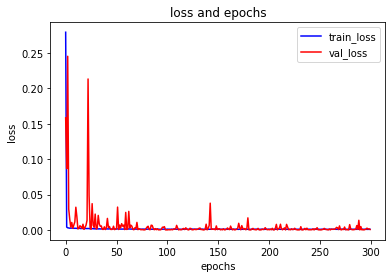

In [20]:
plt.title("loss and epochs")
plt.plot(history.history['loss'],color = 'blue',label="train_loss")
plt.plot(history.history['val_loss'],color = 'red',label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()


In [21]:
# #Load the minimum loss weight 
# model = get_bi_gru()
# model.load_weights("./saved_model/the_best_one.h5")

In [22]:
# # Load saved model 
# from tensorflow.keras.models import load_model
# model = load_model("./saved_model/the_best_one.h5")

In [23]:
x_train.shape
y_train.shape

(7088, 4)

In [24]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [25]:
print(y_test_pred[0])

[0.2812141  0.28908408 0.2756927  0.28381586]


In [26]:
print( y_test_pred[:, 1][0])

0.28908408


In [27]:
def plot_compare(x):
    Col = {'Open':0, 'High':1, 'Low':2, 'Close':3}
    ft = Col[x]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
             color='gray', label='val target')
    plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
            color='red', label='train prediction') 
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
            y_val_pred[:, ft], color='orange', label='val prediction')
    plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
            y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color ='green', label='test prediction')
    plt.title('past and future stock price')
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color='green', label='test prediction')
    plt.title('future stock prices '+x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')



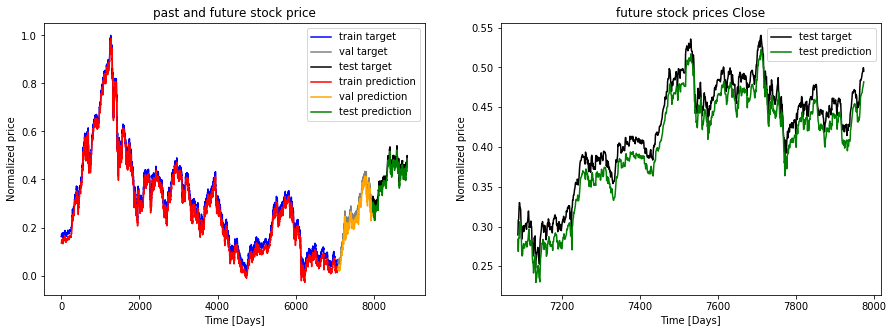

In [28]:
plot_compare('Close')

In [29]:
model.save("saved_model/best_one.h5")

In [30]:
model.evaluate(x_test,y_test)

886/886 [==============================] - 0s 563us/sample - loss: 4.9273e-04 - mean_squared_error: 4.9273e-04


[0.0004927278341279779, 0.0004927278]

In [31]:
model.evaluate(x_val,y_val)

886/886 [==============================] - 1s 567us/sample - loss: 6.8620e-04 - mean_squared_error: 6.8620e-04


[0.0006862007012920829, 0.0006862008]

In [32]:
model.evaluate(x_train,y_train)

7088/7088 [==============================] - 4s 589us/sample - loss: 6.4168e-04 - mean_squared_error: 6.4168e-04


[0.0006416802695042057, 0.00064168026]